In [1]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, clean_llm_output, prompt_enhancer, load_artifact
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gemini-2.5-pro")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-10-02 15:54:49,652 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation


2025-10-02 15:54:50,299 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-pro latency_ms=None artifacts_path=None


✅ Using gemini-2.5-pro for vision tasks


In [2]:
import json


with open("../documents/template_PRD.md", "r", encoding="utf-8") as f:
    officialPRD = f.read()

features_prompt = """
Acting as a senior UI/UX designer, your task is to take the supplied PRD file and extract a comprehensive 
list of screens required to satisfy the needs of functional requirements for version 1.0 of the product.
The screens you will identify will be a dashboard screen for an admin user to monitor/edit job postings and their statuses with a list of applicants, 
a job posting screen which will display job details and a list of applicants and their respective statuses with an ability to add a new applicant,
and an about us screen which will display information about the company and its mission.
The required output is a JSON array of objects with each object containing the following fields:
- screen_name: A concise name for the screen (e.g., "Dashboard Overview", "Job Posting").
- description: A comprehensive description of the screen's purpose and functionality that will be used as a prompt for AI to generate an image capturing the screen's design.
- Format the output in a JSON array format without the ```JSON``` fences.
<PRD Context>
{officialPRD}
</PRD Context>
"""

print(f"Generating all required screens...")
if officialPRD:
    arrayOfSCreens = get_completion(features_prompt, vision_client, vision_model_name, vision_api_provider)
    usable_screens = json.loads(arrayOfSCreens)
    print(usable_screens)

Generating all required screens...
[{'screen_name': 'Admin Dashboard', 'description': "A modern, clean, and professional dashboard UI for a web application. The screen is for an admin user to manage job postings. It features a left-hand navigation sidebar with icons for 'Dashboard', 'Jobs', 'Settings', and 'Profile'. The main content area has a title 'Job Postings Dashboard'. Below the title are three key metric cards: 'Total Open Positions', 'New Applicants (Last 7 Days)', and 'Total Hired'. The primary feature is a data table listing all job postings. The table columns are 'Job Title', 'Department', 'Status' (using colored tags like green for 'Open', blue for 'Draft', and gray for 'Closed'), 'Applicants', and 'Actions'. Each row has action icons for 'View Details', 'Edit', and 'Archive'. In the top right corner of the main content area, there is a prominent primary button labeled '+ Create New Job'."}, {'screen_name': 'Job Posting Details & Applicants', 'description': "A detailed vie

Generating image for screen: Admin Dashboard
✅ Generated image saved to: C:\Users\labadmin\Documents\CohortCaptstone\AI-Enabled-SWE-Capstone\artifacts\screens\image_1759434939.png



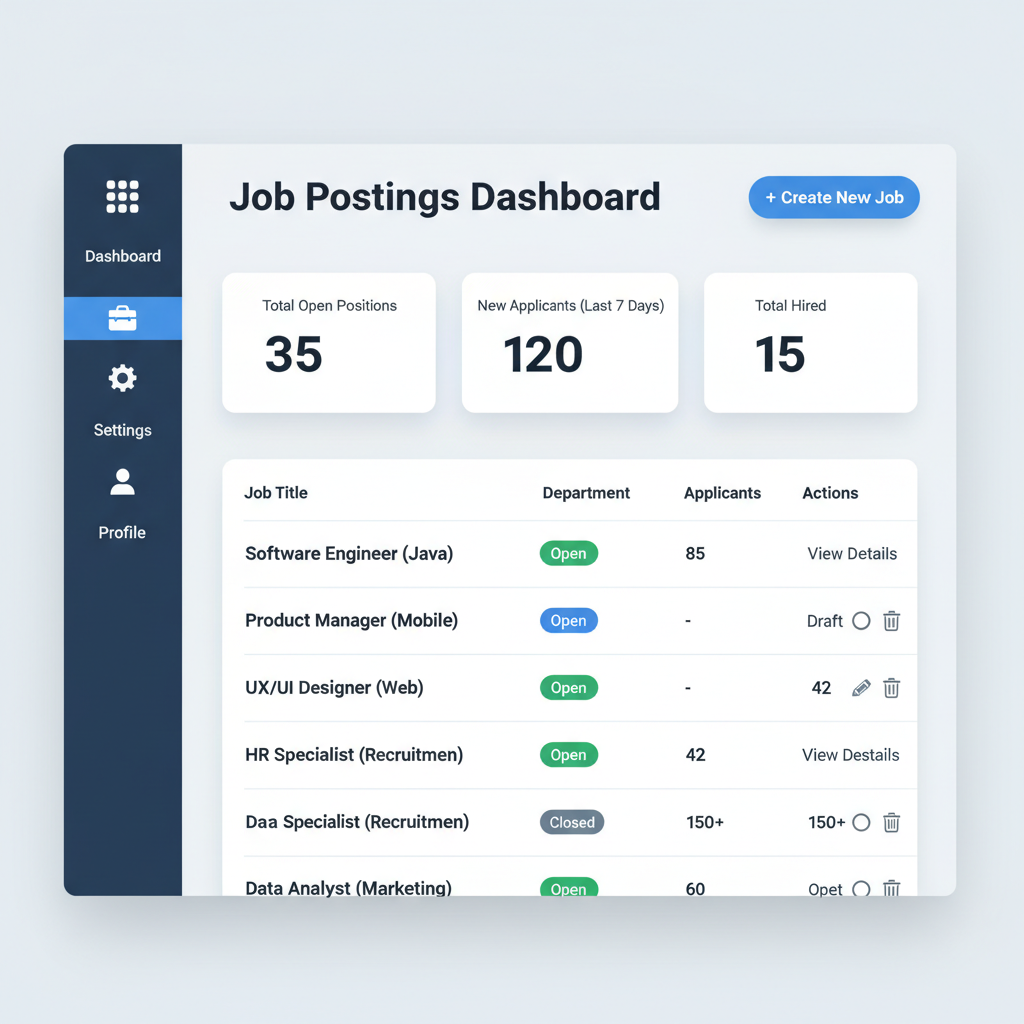

Generating image for screen: Job Posting Details & Applicants
✅ Generated image saved to: C:\Users\labadmin\Documents\CohortCaptstone\AI-Enabled-SWE-Capstone\artifacts\screens\image_1759434947.png



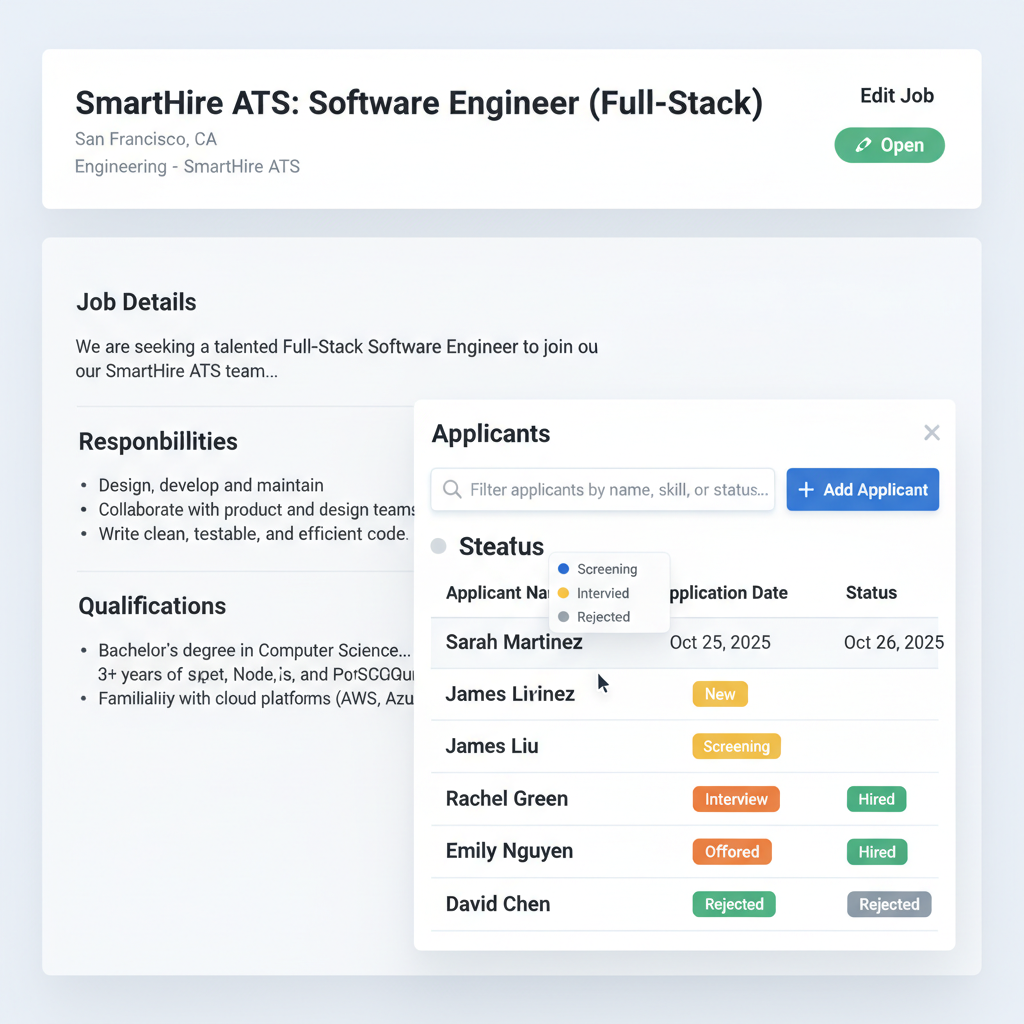

Generating image for screen: About Us
✅ Generated image saved to: C:\Users\labadmin\Documents\CohortCaptstone\AI-Enabled-SWE-Capstone\artifacts\screens\image_1759434954.png



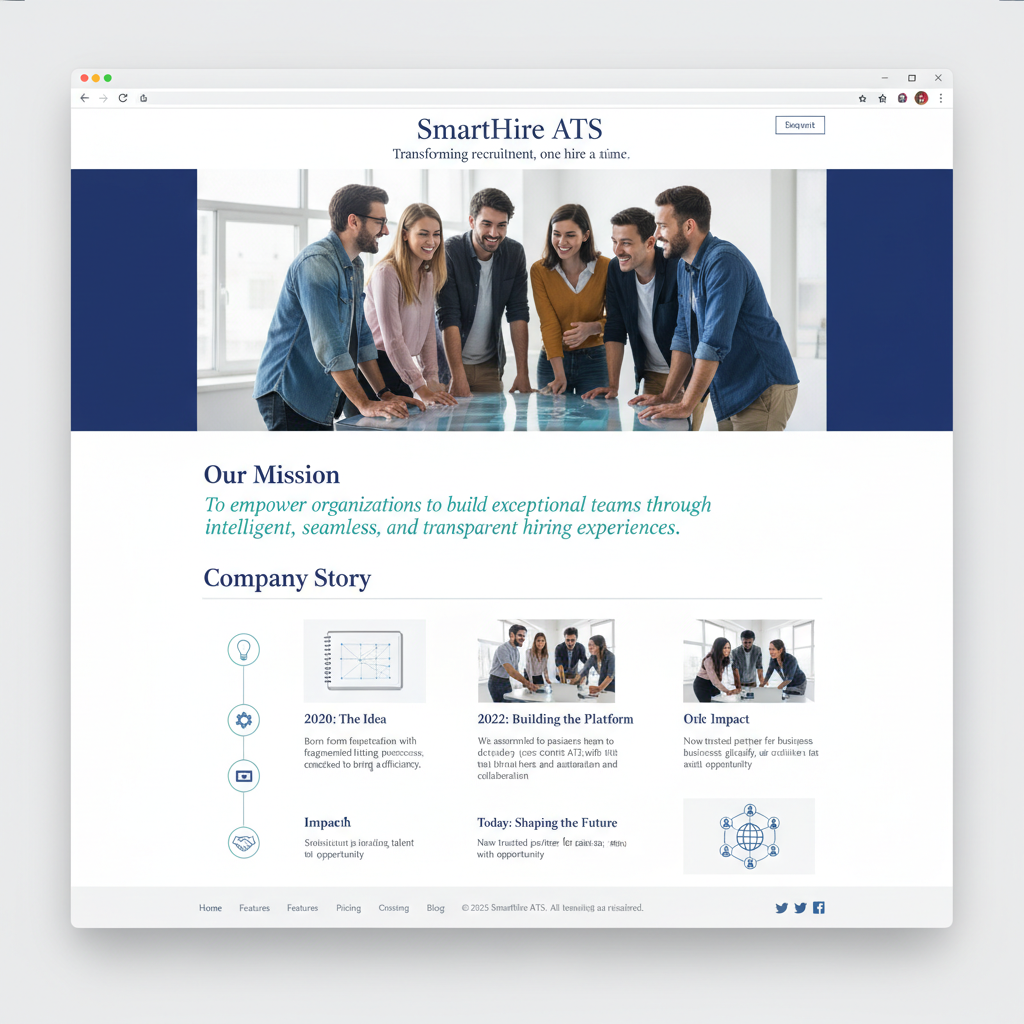

In [3]:
with open("../documents/template_PRD.md", "r", encoding="utf-8") as f:
    cleaned_schema = f.read()

for screen in usable_screens:
    screen_generation_prompt = f"""
    Acting as a senior UI/UX designer. Your job is to take the supplied object and its information and generate a detailed image of a screen for
    a web application that captures the requirements described by the object description field.
    <Screen Description>
    {screen['description']}
    </Screen Description>
    Ensure that any data that maybe shown or captured on the screen is relevant to the supplied Schema file.
    <Schema>
    {cleaned_schema}
    </Schema>
    The output should be a modern, user-friendly, and visually appealing image showing potential design of required screens that aligns with current
    UI/UX best practices.
    """
    print(f"Generating image for screen: {screen['screen_name']}")
    file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)
    # Display the generated image if successful
    if file_path and image_url:
        print(f"✅ Generated image saved to: {file_path}")
        display(Image(url=image_url))
    elif image_url:
        print(f"❌ Image generation failed: {image_url}")
    else:
        print("❌ Image generation returned no result")

In [4]:

folder_path = "../documents/screens"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):  # Only process files, not subdirectories
        print(f"Processing file: {filename}")
        screen_code_prompt = f"""
        You are an expert frontend developer specializing in React and Tailwind CSS.
        Your task is to analyze the provided image of a web application screen and write the code for a single, self-contained React 
        component that accurately replicates its design and layout.
        **Requirements:**
        - Use functional components.
        - Use Tailwind CSS for all styling. Do not use custom CSS or style tags.
        - Make sure the component is accessible, using appropriate HTML tags and attributes.
        - The output should be only the raw JSX code for the component.
        <Image>
        {file_path}
        </Image>
        """
        if vision_model_name:
            initial_JsxCode = get_vision_completion(screen_code_prompt, file_path, vision_client, vision_model_name, vision_api_provider)
            cleaned_JsxCode = clean_llm_output(initial_JsxCode, language="jsx")
            with open(f"../documents/screens/screens_react_code/{filename}.jsx", "w") as f:
                f.write(cleaned_JsxCode)
            print(f"✅ Generated React component code for {filename} and saved to ../documents/screens/screens_react_code/{filename}.jsx")
        else:
            print("Skipping image explanation because no vision model is configured.")

Processing file: AboutUs.png
✅ Generated React component code for AboutUs.png and saved to ../documents/screens/screens_react_code/AboutUs.png.jsx
Processing file: AddApplicantModal.png
✅ Generated React component code for AddApplicantModal.png and saved to ../documents/screens/screens_react_code/AddApplicantModal.png.jsx
Processing file: Dashboard.png
✅ Generated React component code for Dashboard.png and saved to ../documents/screens/screens_react_code/Dashboard.png.jsx
Processing file: JobDetails.png
✅ Generated React component code for JobDetails.png and saved to ../documents/screens/screens_react_code/JobDetails.png.jsx
